<a href="https://colab.research.google.com/github/dauvannam321/UDLBook/blob/main/Chap17/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch import optim
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
torch.manual_seed(42)
np.random.seed(42)

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_size = 0.9
lr = 1e-3
eps = 1e-8
batch_size = 256
epochs = 30

In [3]:
def mnist(train_part, transform=None):
    dataset = torchvision.datasets.MNIST('.', download=True, transform=transform)
    train_part = int(train_part * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_part, len(dataset) - train_part])
    return train_dataset, test_dataset

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset, test_dataset = mnist(train_size, transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
dataloaders = (train_dataloader, test_dataloader)

100%|██████████| 9912422/9912422 [00:00<00:00, 116333117.63it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 55771498.08it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 124494012.76it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20374897.08it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
def noisify(shapes):
    return np.random.normal(loc=0.5, scale=0.3, size=shapes)

In [6]:
def plotn(n, data, noisy=False, super_res=None):
    fig, ax = plt.subplots(1, n)
    for i, z in enumerate(data):
        if i == n:
            break
        preprocess = z[0].reshape(1, 28, 28) if z[0].shape[1] == 28 else z[0].reshape(1, 14, 14) if z[0].shape[1] == 14 else z[0]
        if super_res is not None:
            _transform = transforms.Resize((int(preprocess.shape[1] / super_res), int(preprocess.shape[2] / super_res)))
            preprocess = _transform(preprocess)

        if noisy:
            shapes = list(preprocess.shape)
            preprocess += noisify(shapes)

        ax[i].imshow(preprocess[0])
    plt.show()

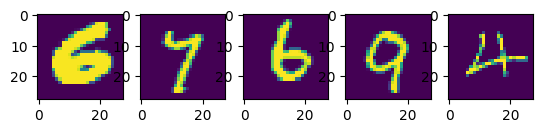

In [7]:
plotn(5, train_dataset)

In [8]:
class VAEEncoder(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.intermediate_dim = 512
        self.latent_dim = 2
        self.linear = nn.Linear(784, self.intermediate_dim)
        self.z_mean = nn.Linear(self.intermediate_dim, self.latent_dim)
        self.z_log = nn.Linear(self.intermediate_dim, self.latent_dim)
        self.relu = nn.ReLU()
        self.device = device

    def forward(self, input):
        bs = input.shape[0]

        hidden = self.relu(self.linear(input))
        z_mean = self.z_mean(hidden)
        z_log = self.z_log(hidden)

        eps = torch.FloatTensor(np.random.normal(size=(bs, self.latent_dim))).to(device)
        z_val = z_mean + torch.exp(z_log) * eps
        return z_mean, z_log, z_val

In [9]:
class VAEDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.intermediate_dim = 512
        self.latent_dim = 2
        self.linear = nn.Linear(self.latent_dim, self.intermediate_dim)
        self.output = nn.Linear(self.intermediate_dim, 784)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        hidden = self.relu(self.linear(input))
        decoded = self.sigmoid(self.output(hidden))
        return decoded

In [85]:
class VAEAutoEncoder(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.encoder = VAEEncoder(device)
        self.decoder = VAEDecoder()
        self.z_vals = None

    def forward(self, input):
        bs, c, h, w = input.shape[0], input.shape[1], input.shape[2], input.shape[3]
        input = input.view(bs, -1)
        encoded = self.encoder(input)
        self.z_vals = encoded
        decoded = self.decoder(encoded[2])
        return decoded

    def get_zvals(self):
        return self.z_vals

In [11]:
def vae_loss(preds, targets, z_vals):
    mse = nn.MSELoss()
    reconstruction_loss = mse(preds, targets.view(targets.shape[0], -1)) * 784.0
    temp = 1.0 + z_vals[1] - torch.square(z_vals[0]) - torch.exp(z_vals[1])
    kl_loss = -0.5 * torch.sum(temp, axis=-1)
    return torch.mean(reconstruction_loss + kl_loss)

In [12]:
model = VAEAutoEncoder(device).to(device)
optimizer = optim.RMSprop(model.parameters(), lr=lr, eps=eps)

In [13]:
def train_vae(dataloaders, model, optimizer, epochs, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]

    train_losses = []
    test_losses = []
    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch
            imgs = imgs.to(device)
            labels = labels.to(device)

            preds = model(imgs)
            z_vals = model.get_zvals()
            loss = vae_loss(preds, imgs, z_vals)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                imgs = imgs.to(device)
                labels = labels.to(device)

                preds = model(imgs)
                z_vals = model.get_zvals()
                loss = vae_loss(preds, imgs, z_vals)

                test_loss += loss.item()

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        tqdm_dct = {'train loss:': train_loss, 'test loss:': test_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

    return train_losses, test_losses

In [14]:
history = train_vae(dataloaders, model, optimizer, epochs, device)

100%|██████████| 30/30 [06:28<00:00, 12.94s/it, train loss:=35.2, test loss:=35.8]


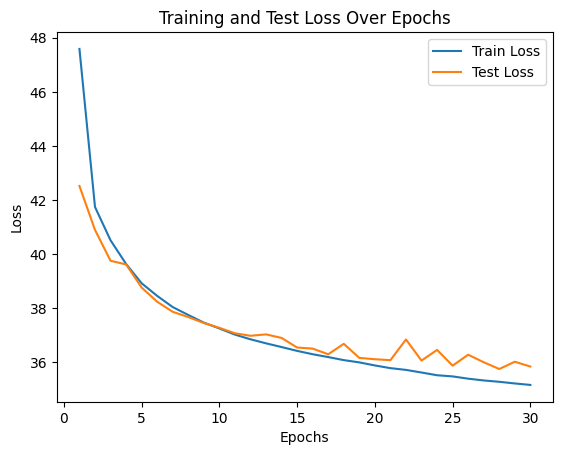

In [15]:
# Example data (replace these lists with your actual data)
train_loss, test_loss = history

# Plotting the training and test loss
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, test_loss, label='Test Loss')

# Adding labels and a legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()

# Display the plot
plt.show()

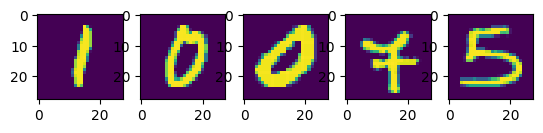

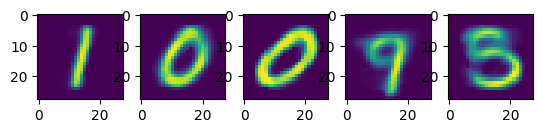

In [36]:
model.eval()
predictions = []
plots = 5
for i, data in enumerate(test_dataset):
    if i == plots:
        break
    predictions.append(model(data[0].to(device).unsqueeze(0)).view(1, 28, 28).detach().cpu())
plotn(plots, test_dataset)
plotn(plots, predictions)

In [46]:
print(predictions[0].shape)

torch.Size([1, 28, 28])


# **Generate image**

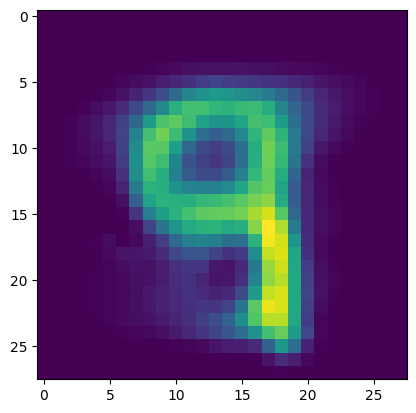

In [156]:
output = _
for batch in train_dataloader:
  imgs, labels = batch
  imgs = imgs.to(device)
  base_img_to_get_generate = imgs[0]
  output = model(base_img_to_get_generate.to(device).unsqueeze(0)).view(1, 28, 28).detach().cpu()

  image_array = output.view(28,28).detach().cpu().numpy()

  # Plot the image
  plt.imshow(image_array)
  plt.show()
  break

In [157]:
z_mean, z_log, z_value = model.get_zvals()

In [158]:
def reparameterize(mu, logvar):
  std = torch.exp(0.5 * logvar)
  eps = torch.randn_like(std)
  return eps * std + mu

In [159]:
new_z_value = reparameterize(z_mean, z_log)

In [160]:
generated_img = model.decoder(z_value)
generated_img1 = model.decoder(new_z_value)

In [161]:
def plot_result(generated_img):
  image_tensor = generated_img.view(28, 28)

  # Convert to a NumPy array for plotting
  image_array = image_tensor.detach().cpu().numpy()
  # Plot the image
  plt.imshow(image_array)
  plt.show()

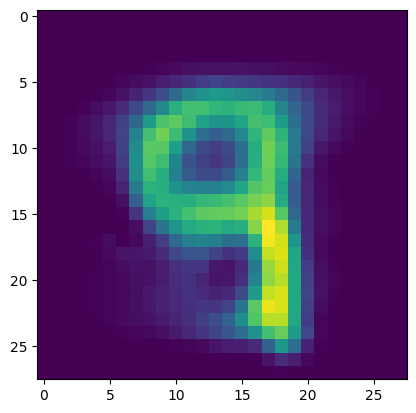

In [162]:
plot_result(generated_img)

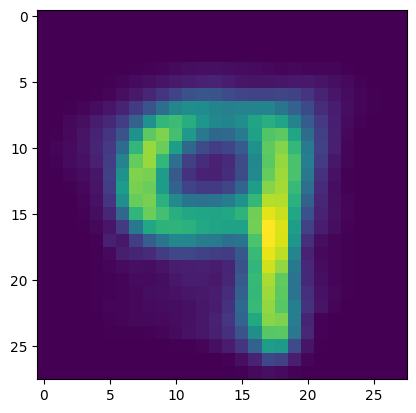

In [163]:
plot_result(generated_img1)